## Latent Dirichlet Allocation (LDA) with Python
**Author:** [Jordan Barber](http://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html) <br>
**Modified by:** [Lehlohonolo Makoti](https://github.com/lmakoti) <br>
**Notebook/Application:** [Databricks Notebooks](https://docs.databricks.com/en/notebooks/index.html)

## What is Latent Dirichlet Allocation
**Latent Dirichlet Allocation (LDA)** is a statistical model that is used to classify or categorize large sets of data, like documents, into topics. Imagine you have a bunch of newspaper articles, but you don't know what topics they cover. LDA helps by identifying groups of words (topics) that often appear together in these articles. Each article can contain multiple topics in different proportions. For instance, an article might be 70% about sports, 20% about politics, and 10% about the economy. The `"latent"` part means that these topics are hidden (not directly observed) and are inferred from the words in the documents. The `"Dirichlet"` part refers to the specific type of statistical distribution used in the model to handle the variability of topics in documents.


## Packages Required

This walkthrough uses the following Python packages:
* [NLTK](https://pypi.org/project/nltk/), a natural language toolkit for Python. A useful package for any natural language processing.<br>
For Mac/Unix with pip: `$ sudo pip install -U nltk`
* [stop_words](https://pypi.org/project/stop-words/), a Python package containing stop words.<br>
For Mac/Unix with pip: `$ sudo pip install stop-words`
* [gensim](https://pypi.org/project/gensim/), a topic modeling package containing our LDA model.<br>
For Mac/Unix with pip: `$ sudo pip install gensim`

**Databricks:** `%pip install <package_name>`



In [0]:
# Inline library installation
%pip install nltk
%pip install stop-words
%pip install gensim

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 773.9/773.9 kB 39.4 MB/s eta 0:00:00
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32893 sha256=d83556ada6e46fd82ab07a806d1d817e18d7cc644b617eb10a3d82c59c179f4c
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
Successfully built stop-words
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to r

## 1. Importing the Documents (API/Scrapping/Corpora etc.)

In [0]:
## Import the documents - Any sources are acceptable
doc_a = "Brocolli is good to eat. My brother likes to eat good brocolli, but not my mother."
doc_b = "My mother spends a lot of time driving my brother around to baseball practice."
doc_c = "Some health experts suggest that driving may cause increased tension and blood pressure."
doc_d = "I often feel pressure to perform well at school, but my mother never seems to drive my brother to do better."
doc_e = "Health professionals say that brocolli is good for your health."

# compile sample documents into a list
doc_set = [doc_a, doc_b, doc_c, doc_d, doc_e]

## 2. Text Preprocessing (Cleaning the Documents)
Preprocessing text is essential for Latent Dirichlet Allocation (LDA) and other natural language processing tasks for several reasons:

* **Tokenisation:** This involves breaking down text into individual words or terms (tokens). It's a fundamental step for the LDA model to understand and process the text data.

* **Reducing Dimensionality (Stopwords removal):** Text data can be very high-dimensional due to the vast number of unique words. Preprocessing steps like removing common stopwords (e.g., "the", "is", "and") reduces the dimensionality, making the LDA model more efficient and effective.

* **Stemming/Lemmatization:** These processes reduce words to their root form. For example, "running", "ran", and "runs" would all be reduced to "run". This helps in consolidating the variations of a word into a single term, improving the model's ability to identify relevant topics.

* **Removing Noise:** Text data often contains elements like special characters, punctuation, and numbers that may not be relevant for topic modeling. Removing these helps focus on meaningful words.

* **Standardisation:** Converting all text to a standard format, typically lower case, ensures that the algorithm treats words like "Apple" and "apple" as the same word.

* **Removing Rare Words:** Words that appear very infrequently may not be useful in identifying common themes and topics. Removing these can help improve the model's focus and performance.

By preprocessing text, you essentially clean and refine the data, making it more suitable for the LDA model to analyze and draw meaningful conclusions about the underlying topics in the text.

### 2.1 Tokenisation/Lowercasing


In [0]:
from nltk.tokenize import RegexpTokenizer
import re

tokenizer = RegexpTokenizer(r'\w+')

# standardisation/lowering the case
raw = doc_a.lower()
tokens = tokenizer.tokenize(raw)

In [0]:
# handling special text and characters
# Remove special characters
doc_a = re.sub(r'[^\w\s]', '', doc_a)

# Remove HTML/XML tags
doc_a = re.sub(r'<[^>]+>', '', doc_a)

# Remove phone numbers (US format)
doc_a = re.sub(r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b', '', doc_a)

# Example of removing simple JSON/XML structures (not recommended for complex structures)
# doc_a = re.sub(r'\{.*?\}', '', doc_a) # for simple JSON
# doc_a = re.sub(r'<.*?>', '', doc_a) # for simple XML

### 2.2 Stopwords Removal/Handling

In [0]:
from stop_words import get_stop_words
# create English stop words list
en_stop = get_stop_words('en')

### 2.3 Stemming/Lemmatisation

In [0]:
# Stemmer instantiation
from nltk.stem.porter import PorterStemmer

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

In [0]:
import nltk

# Lemmatiser instantiation
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
nltk.download("omw-1.4")

# Initialize wordnet lemmatizer
wnl = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## 3. Constructing a Document-Term Matrix
The result of our cleaning stage is texts, a tokenized, stopped and stemmed list of words from a single document. Let’s fast forward and imagine that we looped through all our documents and appended each one to texts. So now texts is a list of lists, one list for each of our original documents.

To generate an LDA model, we need to understand how frequently each term occurs within each document. To do that, we need to construct a document-term matrix with a package called gensim:
```python
from gensim import corpora, models
dictionary = corpora.Dictionary(texts)
```

The Dictionary() function traverses texts, assigning a unique integer id to each unique token while also collecting word counts and relevant statistics. To see each token’s unique integer id, try print(dictionary.token2id).

Next, our dictionary must be converted into a bag-of-words:

`corpus = [dictionary.doc2bow(text) for text in texts]`

The doc2bow() function converts dictionary into a bag-of-words. The result, corpus, is a list of vectors equal to the number of documents. In each document vector is a series of tuples. As an example, print(corpus[0]) results in the following:

```python
print(corpus[0])
[(0, 2), (1, 1), (2, 2), (3, 2), (4, 1), (5, 1)]
```

This list of tuples represents our first document, doc_a. The tuples are (term ID, term frequency) pairs, so if print(dictionary.token2id) says brocolli’s id is 0, then the first tuple indicates that brocolli appeared twice in doc_a. doc2bow() only includes terms that actually occur: terms that do not occur in a document will not appear in that document’s vector.

## 4. Applying the LDA model
**Theory:** https://github.com/lmakoti/topic-modelling

`corpus` is a document-term matrix and now we’re ready to generate an LDA model:

```python
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=3, id2word = dictionary, passes=20)
```
The LDAModel class is described in detail in the [gensim documentation](https://radimrehurek.com/gensim/models/ldamodel.html). Parameters used in our example:
* `num_topics`: (required) An LDA model requires the user to determine how many topics should be generated. Our document set is small, so we’re only asking for three topics.
* `id2word`: (required) The LdaModel class requires our previous dictionary to map ids to strings.
* `passes`: (optional) The number of laps the model will take through corpus. The greater the number of passes, the more accurate the model will be. A lot of passes can be slow on a very large corpus.


## 5. Examining the Results

Our LDA model is now stored as ldamodel. We can review our topics with the print_topic and print_topics methods:

```python
print(ldamodel.print_topics(num_topics=3, num_words=3))
['0.141*health + 0.080*brocolli + 0.080*good', '0.060*eat + 0.060*drive + 0.060*brother', '0.059*pressur + 0.059*mother + 0.059*brother']
```

What does this mean? Each generated topic is separated by a comma. Within each topic are the three most probable words to appear in that topic. Even though our document set is small the model is reasonable. Some things to think about: - health, brocolli and good make sense together. - The second topic is confusing. If we revisit the original documents, we see that drive has multiple meanings: driving a car and driving oneself to improve. This is something to note in our results. - The third topic includes mother and brother, which is reasonable.

Adjusting the model’s number of topics and passes is important to getting a good result. Two topics seems like a better fit for our documents:

ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=2, id2word = dictionary, passes=20)

```python
print(ldamodel.print_topics(num_topics=2, num_words=4))
['0.054*pressur + 0.054*drive + 0.054*brother + 0.054*mother', '0.070*brocolli + 0.070*good + 0.070*health + 0.050*eat']
```

## 6. Putting Everything Together
This explanation is a little lengthy, but useful for understanding the model we worked so hard to generate.

LDA assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution, like the ones in our walkthrough model. In other words, LDA assumes a document is made from the following steps:

* Determine the number of words in a document. Let’s say our document has 6 words.
* Determine the mixture of topics in that document. For example, the document might contain 1/2 the topic “health” and 1/2 the topic “vegetables.”
* Using each topic’s multinomial distribution, output words to fill the document’s word slots. In our example, the “health” topic is 1/2 our document, or 3 words. The “health” topic might have the word “diet” at 20% probability or “exercise” at 15%, so it will fill the document word slots based on those probabilities.

Given this assumption of how documents are created, LDA backtracks and tries to figure out what topics would create those documents in the first place.

In [0]:
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim

tokenizer = RegexpTokenizer(r'\w+')

# create English stop words list
en_stop = get_stop_words('en')

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()
    
# create sample documents
doc_a = "Brocolli is good to eat. My brother likes to eat good brocolli, but not my mother."
doc_b = "My mother spends a lot of time driving my brother around to baseball practice."
doc_c = "Some health experts suggest that driving may cause increased tension and blood pressure."
doc_d = "I often feel pressure to perform well at school, but my mother never seems to drive my brother to do better."
doc_e = "Health professionals say that brocolli is good for your health." 

# compile sample documents into a list
doc_set = [doc_a, doc_b, doc_c, doc_d, doc_e]

# list for tokenized documents in loop
texts = []

# loop through document list
for i in doc_set:
    
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
    texts.append(stemmed_tokens)

# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
    
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

# generate LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=4, id2word = dictionary, passes=20)

In [0]:
print(ldamodel.print_topics())

[(0, '0.031*"brother" + 0.031*"mother" + 0.031*"drive" + 0.031*"say" + 0.031*"profession" + 0.031*"pressur" + 0.031*"health" + 0.031*"brocolli" + 0.031*"good" + 0.031*"like"'), (1, '0.074*"mother" + 0.074*"brother" + 0.074*"drive" + 0.073*"time" + 0.073*"spend" + 0.073*"basebal" + 0.073*"lot" + 0.073*"around" + 0.073*"practic" + 0.015*"profession"'), (2, '0.063*"brother" + 0.063*"mother" + 0.063*"pressur" + 0.063*"drive" + 0.062*"well" + 0.062*"feel" + 0.062*"better" + 0.062*"never" + 0.062*"often" + 0.062*"school"'), (3, '0.099*"good" + 0.099*"brocolli" + 0.099*"health" + 0.068*"eat" + 0.038*"increas" + 0.038*"blood" + 0.038*"caus" + 0.038*"suggest" + 0.038*"tension" + 0.038*"may"')]


In [0]:
print(ldamodel.print_topics(num_topics=3, num_words=3))

[(0, '0.109*"health" + 0.047*"pressur" + 0.047*"drive"'), (1, '0.076*"brother" + 0.076*"mother" + 0.055*"brocolli"')]


In [0]:
print(ldamodel.print_topics(num_topics=2, num_words=4))

[(0, '0.109*"health" + 0.047*"pressur" + 0.047*"drive" + 0.047*"increas"'), (1, '0.076*"brother" + 0.076*"mother" + 0.055*"brocolli" + 0.055*"good"')]


## 7. Visualise the Results

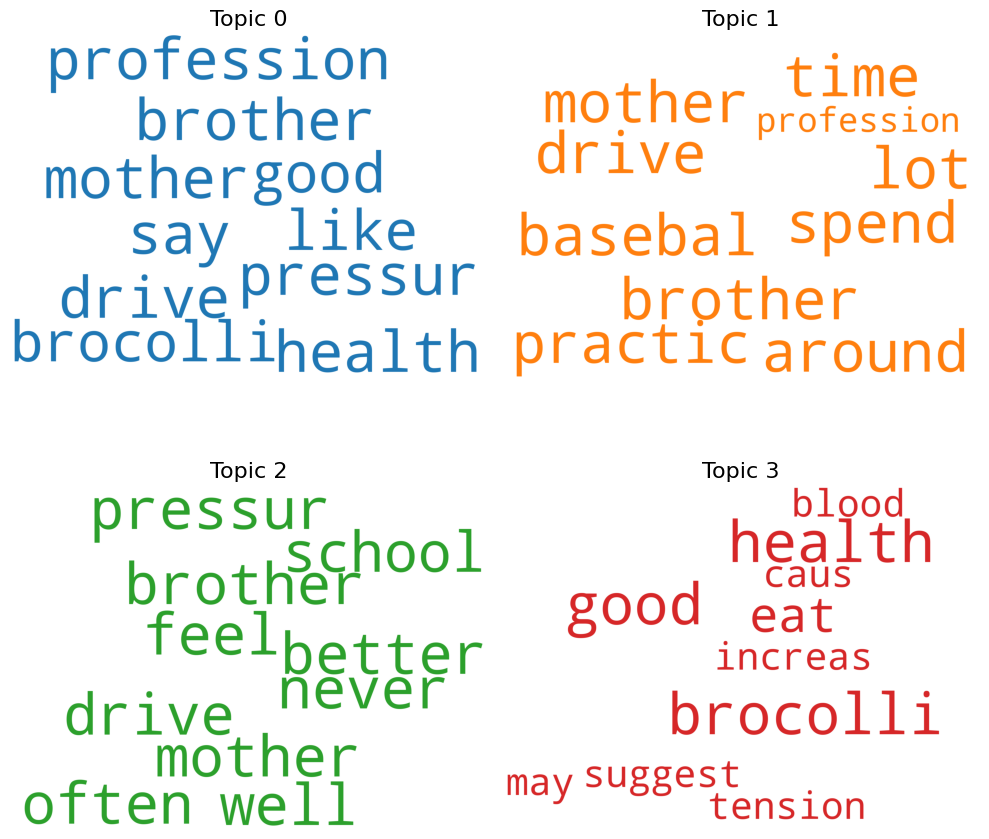

In [0]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopped_tokens,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamodel.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()